In [149]:
!pip uninstall tensorflow tensorflow_gpu protobuf --yes

Uninstalling tensorflow-1.4.0:
  Successfully uninstalled tensorflow-1.4.0
Cannot uninstall requirement tensorflow-gpu, not installed
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [150]:
!pip install protobuf==3.6.0 tensorflow==1.8.0 tensorflow_gpu==1.8.0 --no-cache-dir

    100% |████████████████████████████████| 7.1MB 31.2MB/s ta 0:00:01
    100% |████████████████████████████████| 49.1MB 44.2MB/s ta 0:00:01
    100% |████████████████████████████████| 216.3MB 51.1MB/s ta 0:00:01  4% |█▌                              | 10.1MB 64.2MB/s eta 0:00:04    12% |████                            | 26.3MB 46.4MB/s eta 0:00:05    40% |█████████████                   | 87.2MB 54.0MB/s eta 0:00:03    59% |███████████████████▏            | 129.6MB 53.7MB/s eta 0:00:02    81% |██████████████████████████▏     | 177.2MB 44.7MB/s eta 0:00:01
    100% |████████████████████████████████| 3.1MB 79.4MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 49.6MB/s ta 0:00:01
    100% |████████████████████████████████| 9.3MB 82.0MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 65.5MB/s ta 0:00:01
  Found existing installation: protobuf 3.4.1
    Uninstalling protobuf-3.4.1:
      Successfully uninstalled protobuf-3.4.1
  Found existing installation: htm

In [1]:
import os
import scipy
import os.path
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn
bidynrnn = tf.nn.bidirectional_dynamic_rnn

In [2]:
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def softplus(x):
#     return np.log(1 + np.exp(x)) + 1e-5

# np.random.seed(100) #4, 100
# H = 140
# A = 0.08 * np.random.randn(H, H)
# R = la.expm(A - A.T)
# B = 0.2 * np.random.rand(1, H)
# b = 0.5 * np.random.randn(H, 1)
# c = 0.1 * np.random.randn(H, 1)
# bias_h = np.random.rand(1, H)
# d = 0.01 * np.random.rand(H, 1)

# np.random.seed(0)
# T = 300; N = 100; training_size = 90
# sigma_c = 5.3
# h = np.zeros((N, T + 1, H))
# h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(H), size=N)
# y = np.zeros((N, T + 1, 1))

# for i in range(1, T + 1):
#     h[:, i, :] = np.tanh(np.dot(h[:, i - 1, :], R) + np.dot(y[:, i - 1], B)) + 0.7 * h[:, i - 1, :] + bias_h
#     y[:, i] = (3 * np.dot(h[:, i, :], b) + 4 * np.tanh(np.dot(h[:, i, :], c))
#                + 3 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 2) * np.random.randn(N, 1))

# y = y[:, 1:]
# y_tilde = (y + sigma_c * np.random.randn(N, T, 1))

# seq_length = 150
# offset = 50
# training_data = y_tilde[:training_size, offset:offset+seq_length]
# testing_data = y_tilde[training_size:, offset:offset+seq_length]

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log(1 + np.exp(x)) + 1e-5

np.random.seed(100) #4, 100
H = 140
A = 0.8 * np.random.randn(H, H)
R = la.expm(A - A.T)
B = 2 * np.random.randn(1, H)
b = 0.5 * np.random.randn(H, 1)
c = 0.5 * np.random.randn(H, 1)
bias_h = np.random.rand(1, H)
d = 0.05 * np.random.randn(H, 1)

np.random.seed(0)
T = 300; N = 10000; training_size = 9000
sigma_c = 5.3
h = np.zeros((N, T + 1, H))
h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(H), size=N)
y = np.zeros((N, T + 1, 1))

for i in range(1, T + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i - 1, :], R) + np.tanh(np.dot(y[:, i - 1], B))) + 0.7 * h[:, i - 1, :] + bias_h
    y[:, i] = (1.5 * np.dot(h[:, i, :], b) + 1 * np.tanh(np.dot(h[:, i, :], c))
               + 1 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 10) * np.random.randn(N, 1))

y = y[:, 1:]
y = y - np.mean(y)
y_tilde = (y + sigma_c * np.random.randn(N, T, 1))

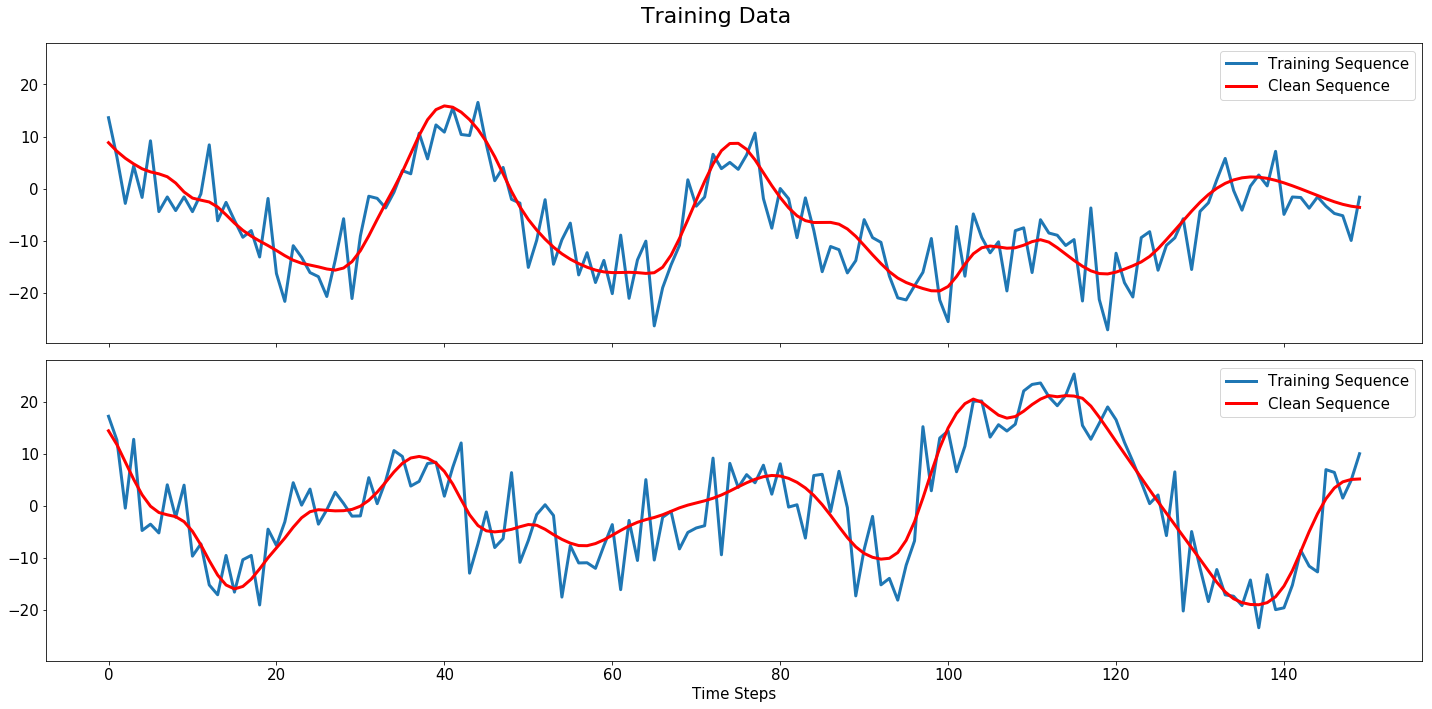

In [35]:
seq_length = 150
offset = 50
training_data = y_tilde[:training_size, offset:offset+seq_length]
testing_data = y_tilde[training_size:, offset:offset+seq_length]

idx = np.random.randint(0, N, 2)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 10))
ax1.plot(y_tilde[idx[0], offset:offset+seq_length], label='Training Sequence', linewidth=3.0)
ax1.plot(y[idx[0], offset:offset+seq_length], 'r', label='Clean Sequence', linewidth=3.0)
ax2.plot(y_tilde[idx[1], offset:offset+seq_length], label='Training Sequence', linewidth=3.0)
ax2.plot(y[idx[1], offset:offset+seq_length], 'r', label='Clean Sequence', linewidth=3.0)
ax2.set_xlabel('Time Steps', fontsize=15)
for ax in (ax1, ax2):
    ax.legend(fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.suptitle('Training Data', fontsize=22)
plt.savefig(path + '/training_data.pdf', bbox_inches='tight')
plt.show()

In [5]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [25]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, reg_lambda=0., reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._regulariser = tf.contrib.layers.l2_regularizer(scale=reg_lambda)
        self._layer_mu = tf.layers.Dense(self._event_size, kernel_regularizer=self._regulariser)
        self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = self._layer_mu(hidden)
        std = self._layer_sigma(hidden)
        return (mean, std), state

class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std, sample), (state, sample)
    
class BeamSamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a Beam Search sequence in auto-regressive mode by sampling and pruning at every step
    """

    def __init__(self, cell, output_size, branch_width, reuse=None):
        super(BeamSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._branch_width = branch_width

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size, 1)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _, state_and_sample_and_prob):
        (state, sample, probs) = state_and_sample_and_prob
        (mean, std), state = self._cell(sample, state)
        dist = tfd.MultivariateNormalDiag(mean, std)
        sample = dist.sample((self._branch_width))
        new_probs = dist.log_prob(sample)
        new_probs = tf.reshape(new_probs, [-1])
        probs = tf.tile(probs[None, ..., 0], [self._branch_width, 1])
        probs = tf.reshape(probs, [-1])
        best_probs, best_idx = tf.nn.top_k(new_probs + probs, k=self._branch_width)
        best_samples = tf.gather(tf.reshape(sample, [-1, self._output_size]), best_idx)

        return (mean, best_samples), (state, best_samples, best_probs[..., None])

In [26]:
class SequenceVAE(object):
    """
    Second baseline
    """

    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size, dim_z=20, future_steps = 30):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        self._Z = dim_z                                           # Z
        self._K = future_steps

        self._branch_width = 5

        self.initialise_variables
        self.q_z = self.make_encoder
        self.p_y = self.make_decoder
        self.compute_elbo
        self.optimise

    @define_scope
    def initialise_variables(self):
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D)
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        self._beam_cell = BeamSamplingCell(self._gauss_cell, self._D, self._branch_width)
        self._post_cell = tfn.GRUBlockCell(self._H)
        self._layer = tf.layers.Dense(self._H)
        self._optimiser = tf.train.AdamOptimizer(0.001)

    @define_scope
    def make_encoder(self):
        _, h = dynrnn(self._post_cell, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z

    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))

    @define_scope
    def make_decoder(self):
        self._code_z = self.q_z.sample((self._Sz))
        hidden = self._layer(tf.reshape(self._code_z, [-1, self._Z]))
        fake_inputs = tf.zeros((self._Sz * self._B, self._T, self._D))
        initial = (hidden, tf.zeros((self._Sz * self._B, self._D)))
        (means, stds, _), _ = dynrnn(self._sampling_cell, inputs=fake_inputs, initial_state=initial)
        return tfd.MultivariateNormalDiag(means, stds)

    @define_scope
    def make_reconstruction(self):
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        return tf.reduce_sum(self.p_y.log_prob(data)) / self._Sz

    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z
        return loss, kl_z, reconstruction

    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

    @define_scope
    def predict_forward_beam(self):
        code_z = self.q_z.sample()[:1]
        hidden = self._layer(code_z)
        inputs = self._data
        _, h = dynrnn(self._cell, inputs=inputs, initial_state=hidden)
        fake_inputs = tf.zeros((self._branch_width, self._K, self._D))
        state_and_sample_and_prob = (tf.tile(h, [self._branch_width, 1]),
                                     tf.tile(inputs[:, -1], [self._branch_width, 1]),
                                     tf.zeros((self._branch_width, 1)))
        
        (_, samples), (_, _, probs) =\
            dynrnn(self._beam_cell, inputs=fake_inputs, initial_state=state_and_sample_and_prob)

        best_idx = tf.argmax(probs)
        return tf.gather(samples, best_idx)

In [34]:
tf.reset_default_graph()
S = 30 
B = 50 
T = 100
I = 20000
H = 50
K = 30
Z = 20
w_lambda = 0.
model_name = 'H_{}_Z_{}_B_{}_T_{}_K_{}'.format(H, Z, B, T, K)
path = './standard_model_{}_no_tf'.format(model_name)
train = True
print_every = 1000
plot = True
restore = False

os.makedirs(path, exist_ok=True)
os.makedirs(path + '/ckpt', exist_ok=True)
os.makedirs(path + '/training_curves', exist_ok=True)

x_ = tf.placeholder(tf.float32, [None, T, 1])
gen_model = SequenceVAE(x_, n_hidden=H, n_samples=S, seq_length=T, batch_size=B, future_steps=K, dim_z=Z)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])

if restore:
    try:
        saver.restore(sess, path + '/ckpt/modelling.ckpt')
        sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'forward' in v.name]))
        
    except tf.errors.NotFoundError as e:
        print('No model to load!')
        sess.run(tf.global_variables_initializer())
    
    try:
        elbos = np.load(os.path.join(path + '/training_curves/elbos.npy')).tolist()
        llks = np.load(os.path.join(path + '/training_curves/llks.npy')).tolist()
        kls = np.load(os.path.join(path + '/training_curves/kls.npy')).tolist()
        test_elbos = np.load(os.path.join(path + '/training_curves/test_elbos.npy')).tolist()
    
    except FileNotFoundError as e:
        print('No training curves to restore')
        
else:
    sess.run(tf.global_variables_initializer())
    
if train:
    elbos = []; kls = []; llks = []; test_elbos = []
    
    try:
        for i in range(I):
            idx = np.random.randint(0, training_size, B)
            batch = training_data[idx, :T]

            elbo, kl, llk = sess.run(gen_model.compute_elbo, {x_: batch})
            elbos.append(elbo); kls.append(kl); llks.append(llk)

            if i % 10 == 0:
                test_idx = np.random.randint(0, testing_data.shape[0], B)
                test_batch = testing_data[test_idx, :T]
                test_elbo, _, _ = sess.run(gen_model.compute_elbo, {x_: test_batch})
                test_elbos.append(test_elbo)

            if i % print_every == 0:
                print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Test ELBO:', test_elbo)
                saver.save(sess, path + '/ckpt/modelling.ckpt')
                np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
                np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
                np.save(os.path.join(path + '/training_curves/kls.npy'), np.stack(kls))
                np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))

            sess.run(gen_model.optimise, {x_: batch})
                
    except KeyboardInterrupt as e:
        pass
            
    saver.save(sess, path + '/ckpt/modelling.ckpt')
    np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
    np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
    np.save(os.path.join(path + '/training_curves/kls.npy'), np.stack(kls))
    np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))

INFO:tensorflow:Scale of 0 disables regularizer.
Iteration: 0 ELBO: -656931.0 KL: 516.204 Reconstruction: -656415.0 Test ELBO: -605976.0
Iteration: 1000 ELBO: -18305.3 KL: 277.907 Reconstruction: -18027.4 Test ELBO: -18138.3
Iteration: 2000 ELBO: -17674.7 KL: 374.545 Reconstruction: -17300.2 Test ELBO: -17835.7
Iteration: 3000 ELBO: -17563.2 KL: 446.987 Reconstruction: -17116.2 Test ELBO: -17603.9
Iteration: 4000 ELBO: -17541.4 KL: 484.005 Reconstruction: -17057.4 Test ELBO: -17300.4
Iteration: 5000 ELBO: -17562.8 KL: 485.102 Reconstruction: -17077.7 Test ELBO: -17312.1
Iteration: 6000 ELBO: -17186.3 KL: 555.007 Reconstruction: -16631.2 Test ELBO: -17070.2
Iteration: 7000 ELBO: -17189.1 KL: 585.637 Reconstruction: -16603.4 Test ELBO: -17166.0
Iteration: 8000 ELBO: -17056.1 KL: 575.428 Reconstruction: -16480.7 Test ELBO: -17112.8
Iteration: 9000 ELBO: -16943.7 KL: 583.146 Reconstruction: -16360.5 Test ELBO: -16989.5
Iteration: 10000 ELBO: -16981.4 KL: 616.19 Reconstruction: -16365.2 Tes

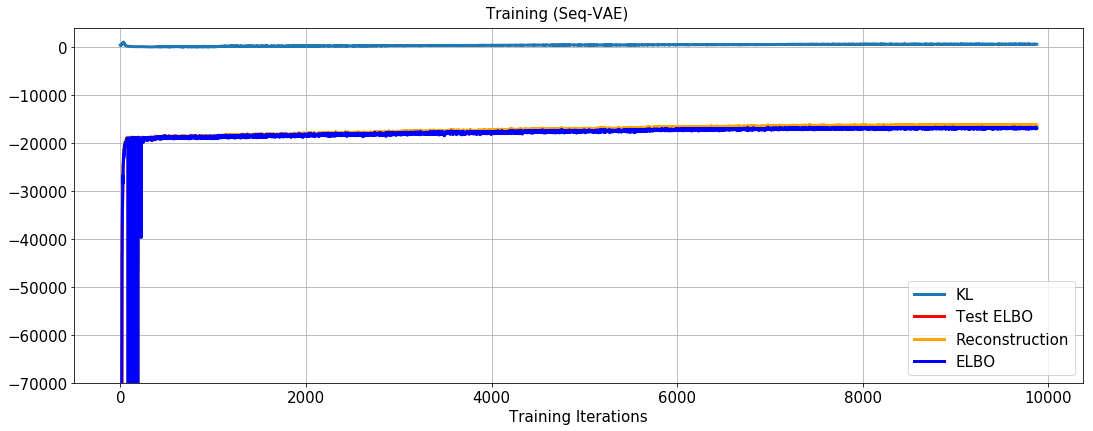

In [28]:
if plot:
    fig, ax = plt.subplots(1, 1, figsize=(15,6))    
    plt.plot(kls, label='KL', linewidth=3.0)
    plt.plot([10 * i for i in range(len(test_elbos))], test_elbos, 'r', label='Test ELBO', linewidth=3.0)
    plt.plot(llks, 'orange', label='Reconstruction', linewidth=3.0)
    plt.plot(elbos, 'b', label='ELBO', linewidth=3.0)
    ax.set_xlabel('Training Iterations', fontsize=15)
    plt.grid("on")
    plt.ylim([-70000, 4000])
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    fig.suptitle('Training (Seq-VAE)', fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
#     plt.savefig(path + '/training_curve.pdf', bbox_inches='tight')
    plt.show()

In [37]:
np.random.seed(0)
idx = np.random.randint(0, testing_data.shape[0], B)
test_batch = testing_data[idx, :T]

means = sess.run(gen_model.p_y.mean(), {x_: test_batch})
samples = sess.run(gen_model.p_y.sample(), {x_: test_batch})

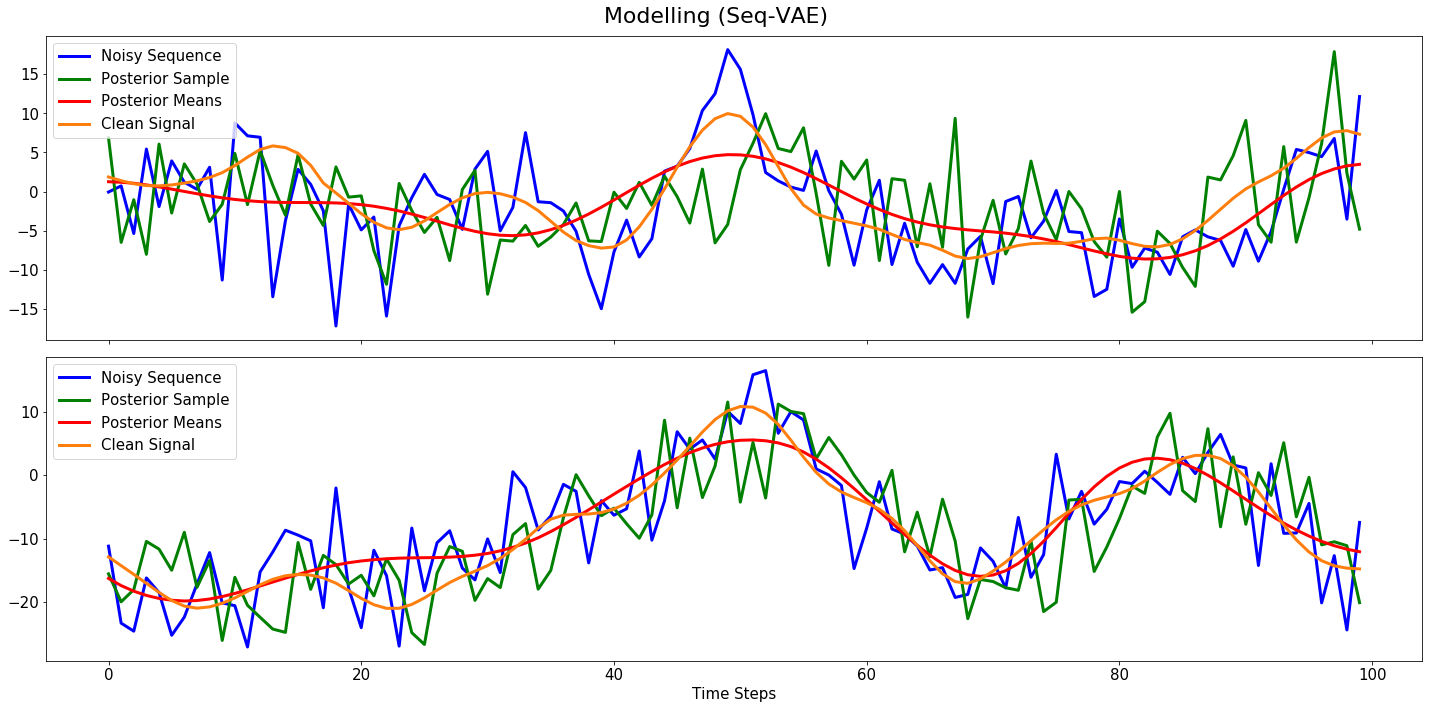

In [38]:
if plot:
    plot_idx = np.random.choice(B, 2, replace=False)
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

    for e, ax in enumerate(axs.flatten()):
        ax.plot(test_batch[plot_idx[e], :], 'b', label='Noisy Sequence', linewidth=3.0)
        ax.plot(np.reshape(samples, (S, B, T))[0, plot_idx[e]] , 'g', label='Posterior Sample', linewidth=3.0)
        ax.plot(np.mean(np.reshape(means, (S, B, T)), 0)[plot_idx[e]], 'r', label='Posterior Means', linewidth=3.0)
        ax.plot([], [])
        ax.plot(y[training_size:][idx[plot_idx[e]], offset:T+offset], label='Clean Signal', linewidth=3.0)
        ax.legend(fontsize=15)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(15);
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(15);
    axs[-1].set_xlabel('Time Steps', fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    fig.suptitle('Modelling (Seq-VAE)', fontsize=22)
#     plt.savefig(path + '/modelling.pdf', bbox_inches='tight')
    plt.show()

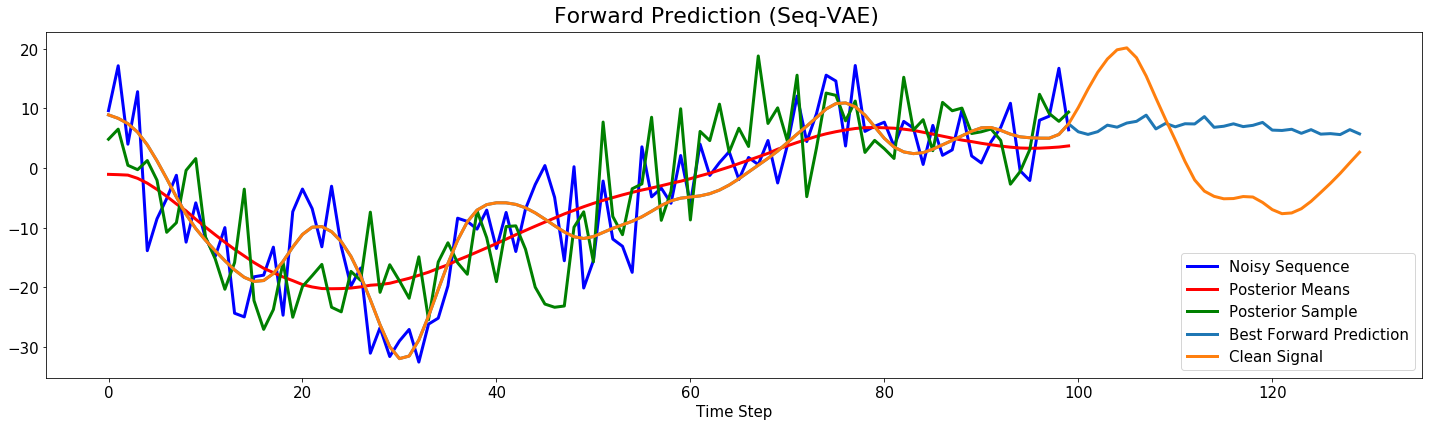

In [33]:
i = 2
continuation = sess.run(gen_model.predict_forward_beam, {x_: test_batch[i:i+1]})

if plot:
    fig, ax = plt.subplots(1,1,figsize=(20,6))
    ax.plot(test_batch[i, :], 'b', label='Noisy Sequence', linewidth=3.0)
    ax.plot(np.mean(np.reshape(means, (S, B, T)), 0)[i], 'r', label='Posterior Means', linewidth=3.0)
    ax.plot(np.reshape(samples, (S, B, T))[0, i] , 'g', label='Posterior Sample', linewidth=3.0)

    plt.plot(np.concatenate([y[training_size:][idx[i], offset:T+offset], continuation[0]], 0),
             label='Best Forward Prediction', linewidth=3.0)
    plt.plot(y[training_size:][idx[i], offset:offset+T+30], label='Clean Signal', linewidth=3.0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    plt.legend(fontsize=15)
    plt.xlabel('Time Step', fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Forward Prediction (Seq-VAE)", fontsize=22)
#     plt.savefig(path + '/prediction_{}.pdf'.format(i), bbox_inches='tight')
    plt.show()